<a href="https://colab.research.google.com/github/natong0308/DOMath-CT-Project/blob/main/New_CT_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def line_integral(f,s,theta):
  N = len(f)
  pts = int(np.ceil(2*np.sqrt(2)*N))
  t = np.linspace(-np.sqrt(2),np.sqrt(2),num=pts)
  x = s*np.sin(theta)+t*np.cos(theta)
  y = -s*np.cos(theta)+t*np.sin(theta)
  cols = np.floor(x*N/2)+N/2
  rows = np.floor(y*N/2)+N/2-1
  v = np.zeros(pts,dtype=object)
  for i in range(pts):
    v[i] = (rows[i],cols[i])
  vset = list(set(v))
  rsum = 0
  for tup in vset:
    if tup[0]>=0 and tup[0]<N and tup[1]>=0 and tup[1]<N:
      rsum += f[int(tup[0])][int(tup[1])]
  return rsum

def radon_transform(f,n=180):
  N = len(f)
  pts = int(np.ceil(2*np.sqrt(2)*N))
  theta = np.linspace(0,np.pi,n)
  s = np.linspace(-np.sqrt(2),np.sqrt(2),pts)
  I = np.zeros(shape = (pts,n))
  for i in range(pts):
    for ii in range(n):
      I[i][ii] = line_integral(f,s[i],theta[ii])
  return I

def update_x(A,i,x,b):
  new_x = x - (np.dot(A[i],x)-b[i])/(np.matmul(A[i],np.matrix.transpose(A[i]))) * np.matrix.transpose(A[i])
  return new_x

In [ ]:
  def backprojection(I):
    M = len(I)
    n = len(I[0])
    # 142 by 180
    K = int(np.floor(M/2/np.sqrt(2)))
    print(K)
    newmatrix = np.array([np.zeros(K) for x in range(K)])

    for i in range(K):
      for j in range(K):
        x = (i-K/2)*2/K
        y = (j-K/2)*2/K

        thetas = np.linspace(0, np.pi, num=n)
        theta_sum = 0
        for theta_index in range(n):
          r = -x*np.sin(thetas[theta_index])+y*np.cos(thetas[theta_index])
          r_index = int(np.round((M-1)*((r+np.sqrt(2))/(2*np.sqrt(2)))))
          theta_sum += (I[r_index][theta_index])*(np.pi/n)
        newmatrix[i][j] = theta_sum/np.pi
      
    return newmatrix

def FBP(I):
    newmatrix = np.fft.fft(I)
    N=len(newmatrix)
    #to find filter
    range_of_k = np.array(range(N))
    range_of_k[N//2+1::] = N-range_of_k[N//2+1::]
    k1 = np.tile(range_of_k, (N,1))
    k2 = np.rot90(k1)
    K = np.sqrt(k1*k1 + k2*k2)
    #find |k|, first column gives frequency filter in reversed order
    kreversed = K[:,0]
    k = kreversed[::-1]
    #multiply each column elementwise by the frequency filter
    for angle in range(len(newmatrix[1])):
      newmatrix[:,angle] = np.multiply(k,newmatrix[:,angle])
    #complete filter step using inverse fourier transform and backprojection
    invfilteredimg = np.fft.ifft(newmatrix)
    return backprojection(invfilteredimg).astype(float)

In [ ]:
def old_Arow(f, r, theta):
  N = len(f)
  pts = int(np.ceil(N*2*np.sqrt(2)))
  t = np.linspace(-np.sqrt(2), np.sqrt(2)-0.00001, num=pts)

  x = t * np.cos(theta) + r * np.sin(theta)
  y = t * np.sin(theta) - r * np.cos(theta)

  cols = np.floor(x*N/2) + N/2
  rows = -np.floor(y*N/2) + N/2 - 1

  v = np.zeros(pts, dtype=object)
  for i in range (pts):
    v[i] = (rows[i], cols[i])
  vset = list(v)

  new_row = np.zeros(N**2)
  for tup in vset:
    if tup[0] >= 0 and tup[0] < N and tup[1] >= 0 and tup[1] < N:
      new_row[int(tup[0]*N + tup[1])] += 1
  
  return new_row

In [ ]:
def new_Arow(f, r, theta):
  N = len(f)
  pts = int(np.ceil(N*20*np.sqrt(2)))
  t = np.linspace(-np.sqrt(2), np.sqrt(2)-0.00001, num=pts)

  x = t * np.cos(theta) -r * np.sin(theta)
  y = t * np.sin(theta) + r * np.cos(theta)

  x = x*N/2 + (N/2)
  y = -y*N/2 + (N/2)
  #print(np.around(x,decimals=3))
  #print(np.around(y,decimals=3))

  Arow = np.zeros(shape = (N+1,N+1))

  for i in range (pts):
    if (x[i] >= 0 and x[i] < N and y[i] >= 0 and y[i] < N):
      lowerY = int(np.floor(y[i]))
      higherY = int(np.floor(y[i])+1)
      leftX = int(np.floor(x[i]))
      rightX = int(np.floor(x[i])+1)
    # bottom left
      if ((y[i]-np.floor(y[i])) < (1-((x[i]-np.floor(x[i]))))):
        lbd1 = y[i]-np.floor(y[i])
        lbd3 = x[i]-np.floor(x[i])
        lbd2 = 1-lbd1-lbd3
        Arow[lowerY,leftX] += lbd2
        Arow[higherY,leftX] += lbd1
        Arow[lowerY,rightX] += lbd3
      else:
        lbd3 = 1-(y[i]-np.floor(y[i]))
        lbd1 = 1-(x[i]-np.floor(x[i]))
        lbd4 = 1-lbd1-lbd3
        Arow[higherY, leftX] += lbd1
        Arow[higherY,rightX] += lbd4
        Arow[lowerY,rightX] += lbd3

  #rowRevised = np.zeros(shape=(N,N))
  #for i in range (len(rowRevised)):
  #  for j in range (len(rowRevised)):
  #    rowRevised[i,j] = (Arow[i,j]+Arow[i+1,j+1]+Arow[i,j+1]+Arow[i+1,j])/4
    
  return np.matrix.flatten(Arow) 

In [ ]:
def initialize(f):
  I = radon_transform(f, n=180)
  N = len(f)
  M = len(I)
  n = len(I[0])

  rs = np.linspace(-np.sqrt(2), np.sqrt(2), num = M)
  thetas = np.linspace(0, np.pi, num=n)

  A = np.zeros(shape = (M*n, (N+1)**2))
  #A = np.zeros(shape = (M*n, N**2))
  for i in range(M):
    for j in range(n):
      A[int(i*n+j)] = new_Arow(f,rs[i],thetas[j])
      # -(N/2*np.sqrt(2))
      #A[int(i*n+j)] = Arow(f,rs[i],thetas[j])
  
  x = np.zeros((N+1)**2)
  #x = np.zeros(N**2)
  b = np.matrix.flatten(I)

  return A,x,b

def update_x(A,i,x,b):
  new_x = x - (np.dot(A[i],x)-b[i])/(np.matmul(A[i],np.matrix.transpose(A[i]))) * np.matrix.transpose(A[i])
  return new_x

In [ ]:
def highdose(f, n=180):
  #image from low dose radiation
  I = radon_transform(f,n=90)
  print(I.shape)
  originaltheta  = np.linspace(0,np.pi,90)
  print(originaltheta)
  #initialize new image, doubling number of theta
  ret = np.zeros((len(f)*2, 180))
  #new r and theta values
  s = np.linspace(-np.sqrt(2),np.sqrt(2),len(f)*2)
  theta = np.linspace(0,np.pi,180)
  #conduct radon transform only on ROI (x,y ranging from 15 to 30) and check which r and theta passes through those points
  thetavalues = np.linspace(0,90,360)
  rvalues = []
  for xstep in range(15,31):
    for ystep in range(15,26):
      for theta in thetavalues:
        x = -1+(2/100)*xstep
        y = -1+(2/100)*ystep
        r = y*(np.cos((np.pi/180)*theta)) - x*(np.sin((np.pi/180)*theta))
        rvalues.append(r)
  #convert rvalues to the nearest points in the newgrid
  newROIvalues = set()
  for val in rvalues:
    abs_difference_function = lambda list_value:abs(list_value-val)
    closest_r = min(s, key=abs_difference_function)
    newROIvalues.add(r)
  for i in range(len(f)*2):
    for ii in range(180):
      r = -np.sqrt(2) + (2*np.sqrt(2)/len(f)*2)*i
      theta = (np.pi/180)*ii
      #not in region of interest, interpolate to find line integral
      if r not in newROIvalues:
      #find nearest line from low dose
      # edit note: indented lines before elif
        abs_difference_function = lambda list_value:abs(list_value-val)
        closest_r = min(s, key=abs_difference_function)
        originalrindex = np.where(s, closest_r)[0][0]
        closest_theta = min(originaltheta==theta, key=abs_difference_function)
        originalthetaindex = np.where(originaltheta,closest_theta)[0][0]
        ret[i][ii] = I[originalrindex][originalthetaindex]
      elif r in newROIvalues:
        # this result goes into a new system matrix B
        ret[i][ii] = line_integral(f,r,theta)
  return ret

In [ ]:
def interpolatelow(I):
  size = len(I)*2
  ret = np.zeros((size, size))
  oldvals = np.linspace(-1,1,len(I))
  newvals = np.linspace(-1,1,size)
  for xindex in range(size):
    for yindex in range(size):
        x = newvals[xindex]
        y = newvals[yindex]
        #find nearest point and take that value
        ret[xindex][yindex] = I[findnearestindex(oldvals,x)][findnearestindex(oldvals,y)]
  return ret

def findnearestindex(array, value):
  min = 2
  index = 0
  for i in range(len(array)):
    absdiff = abs(array[i]-value)
    if (absdiff<min):
      min = absdiff
      index = i
  return i

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


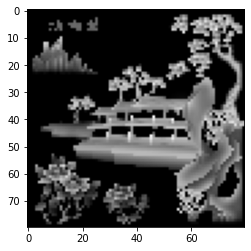

80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


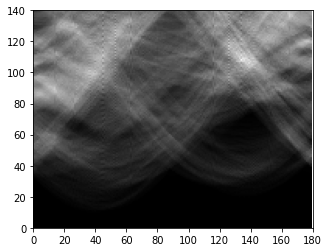

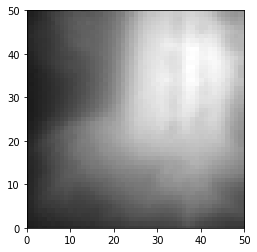

In [ ]:
from PIL import Image
from __future__ import print_function
import cv2
from skimage.data import shepp_logan_phantom
from google.colab import drive
import  matplotlib.pyplot as plt
drive.mount('/content/drive')
#f_im = cv2.imread('/content/drive/My Drive/Colab Notebooks/Screenshot 2021-07-03 at 3.28.50 PM.png', 0)
f_im = cv2.imread('/content/drive/My Drive/Colab Notebooks/eoxl86qo.bmp',0)
f_im = cv2.resize(f_im, dsize=(80,80))
#im = np.zeros((20,20))
#im[1,1] = 255
#im[16:18,16:18] = 255
#f_im = np.resize(f_im, (30,30))
plt.imshow(f_im, cmap='gray')


new_I = radon_transform(f_im, n=180)
plt.show()
plt.imshow(new_I, cmap='gray')
plt.xlim(0,180)
plt.ylim(0,140)

x = FBP(new_I)
plt.show()
plt.imshow(x, cmap='gray')
plt.xlim(0,50)
plt.ylim(0,50)

usableImage = x * 255 / np.amax(x)


Image.fromarray((x-np.amin(x)) * 255/(np.amax(x)-np.amin(x))).show()


In [ ]:
from PIL import Image
import cv2
from skimage.data import shepp_logan_phantom
from google.colab import drive
import  matplotlib.pyplot as plt
drive.mount('/content/drive')
f_im = cv2.imread('/content/drive/My Drive/Colab Notebooks/Screenshot 2021-06-29 at 5.38.51 PM.png', 0)
f_im = cv2.resize(f_im, dsize=(30,30))
#im = np.zeros((20,20))
#im[1,1] = 255
#im[16:18,16:18] = 255
#f_im = np.resize(f_im, (30,30))
plt.imshow(f_im, cmap='gray')


A,x,b = initialize(f_im)

N = len(f_im)
M = int(np.ceil(N*2*np.sqrt(2)))

k = 0
while k < 1000:
  i = 0
  while i < len(A):
    t = np.matrix.transpose(A[i])
    a = np.matmul(A[i], t)
    if a != 0:
      x = update_x(A,i,x,b)
    i += 1
  k += 1
x = np.reshape(x, (N+1,N+1))
#x = np.reshape(x, (N,N))
print(x)
size = len(x)*2
ret = np.zeros((size, size))
oldvals = np.linspace(-1,1,len(x))
newvals = np.linspace(-1,1,size-1)
for xindex in range(len(newvals)):
  for yindex in range(len(newvals)):
      xi = newvals[xindex]
      yi = newvals[yindex]
      if xi and yi in old vals:
        ret[xindex][yindex] = x[np.where(xi,oldvals)]
      ret[xindex][yindex] = x[findnearestindex(oldvals,xi)][findnearestindex(oldvals,yi)]
print(ret)
print('reconstruction')
#print(x)

Image.fromarray(x).show()

#usableImage = x * 255 / np.amax(x)
plt.show()
plt.imshow(ret, cmap='gray')

#Image.fromarray((x-np.amin(x)) * 255/(np.amax(x)-np.amin(x))).show()